In [2]:
%matplotlib inline
import gwpy

In [3]:
from gwosc.datasets import event_gps
from gwpy.timeseries import TimeSeries

gps = event_gps('GW170817')
print("GW170817 GPS:", gps)

ldata = TimeSeries.fetch_open_data('L1', int(gps)-512, int(gps)+512, cache=True)
print("GW170817 data")
print(ldata)

GW170817 GPS: 1187008882.4
GW170817 data
TimeSeries([2.06056010e-20, 1.59181918e-20, 2.18438811e-20, ...,
            1.25504332e-19, 1.23976846e-19, 1.22231459e-19]
           unit: dimensionless,
           t0: 1187008370.0 s,
           dt: 0.000244140625 s,
           name: Strain,
           channel: None)


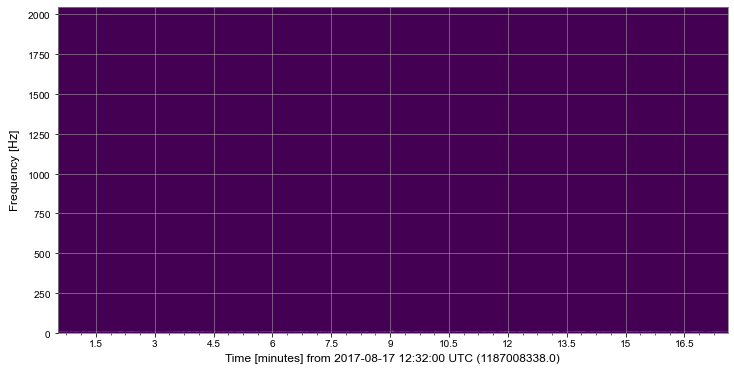

In [4]:
#we can generate our spectrogram using a specific FFT length
#Each of these methods returns the output as stacked power spectral densities, so we take the square root to get back to a familiar amplitude spectral density
specgram = ldata.spectrogram2(fftlength=4, overlap=2, window='hann') ** (1/2.)
plot = specgram.plot()

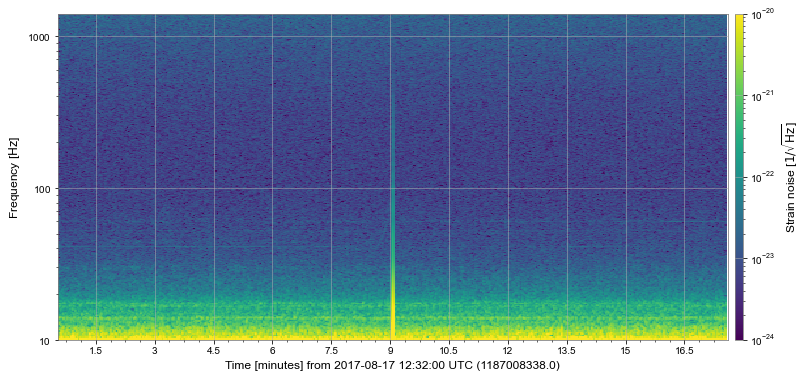

In [5]:
#We can fix this by passing a few more arguments to our plot to control the display (especially the colouring):
ax = plot.gca()
ax.set_yscale('log')
ax.set_ylim(10, 1400)
ax.colorbar(
    clim=(1e-24, 1e-20),
    norm="log",
    label=r"Strain noise [$1/\sqrt{\mathrm{Hz}}$]",
)
plot  # refresh

Here we can see how the ASD for LIGO-Livingston evolves over a ~17 minute span around GW170817.  
Four order of magnitudes in the ASD intensity are involved, and this is why the previous attempt resulted in a (almost) fully dark blue image.

We can see that the low-frequency noise (<30 Hz) rumbles along with some variation, but high frequencies (>100 Hz) are relatively stable. Between 30-100 Hz we can see some narrow features appearing and disappearing as non-stationary noise affects the measurement.

In [6]:
# download the data for all three detectors involved with the GW170814 detection, generate a PSD for each, and make a plot
# make a spectrogram of data for 10 minutes around the GW170817 detection for the LIGO-Livingston detector

### Q-transforms in GWpy

In this section, we will see how we can use a special filter called a Q-transform to create a time-frequency representation of our data that allows use to pick out features at different frequencies, and how they evolve over very short times, without much prior knowledge of the signal morphology.

In [7]:
# reload some data from LIGO Hanford around GW170817:
segment = (int(gps) - 30, int(gps) + 2)
hdata = TimeSeries.fetch_open_data('H1', *segment, verbose=True, cache=True)

Fetched 1 URLs from www.gw-openscience.org for [1187008852 .. 1187008884))
Reading data... [Done]


We can now use the `q_transform()` method of the `hdata` `TimeSeries` to create our time-frequency representation (as a spectrogram).

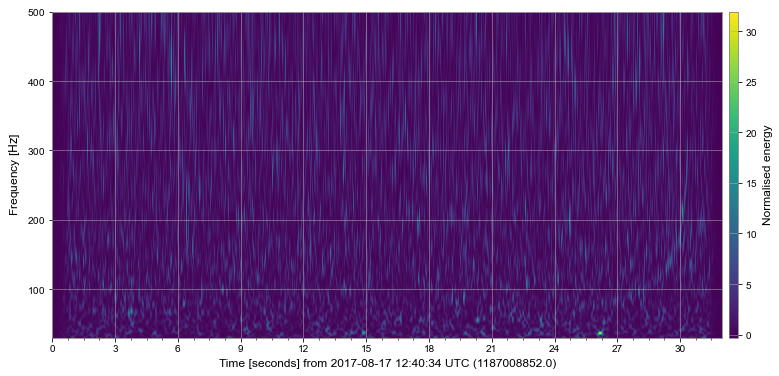

In [8]:
hq = hdata.q_transform(frange=(30, 500))
plot = hq.plot()
plot.colorbar(label="Normalised energy")

Because the Q-transform returns (by default) normalised energy, the low-frequency rumbling is now much less obvious, and we can see better some noises at higher frequencies.

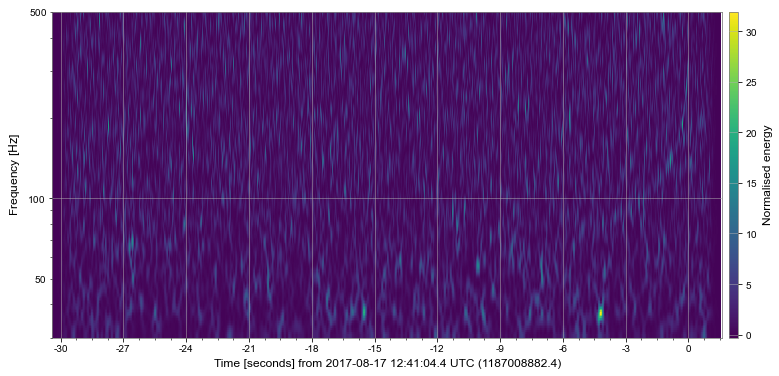

In [9]:
# clean up the display to better visualise the data:
ax = plot.gca()
ax.set_epoch(gps)
ax.set_ylim(30, 500)
ax.set_yscale("log")
plot  # refresh

We can see a more prominent feature starting at ~-6 seconds that looks a little familiar.  
Here we can use our knowledge of the Q-transform, and our hunch about the origin of the 'feature' to choose a more specific range of 'Q' for the Q-transform, so as to better resolve the feature:

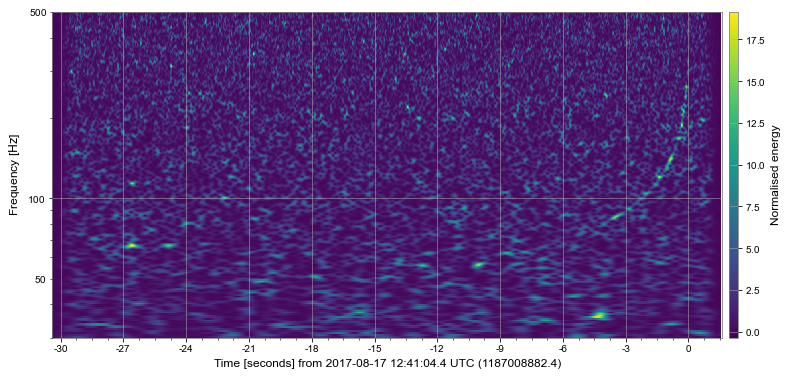

In [10]:
hq = hdata.q_transform(frange=(30, 500), qrange=(100, 110))
plot = hq.plot()
ax = plot.gca()
ax.set_epoch(gps)
ax.set_yscale('log')
ax.colorbar(label="Normalised energy")

Now we see the clear track of a BNS merger, visible from about -4 seconds all the way through to the merger at T=0.

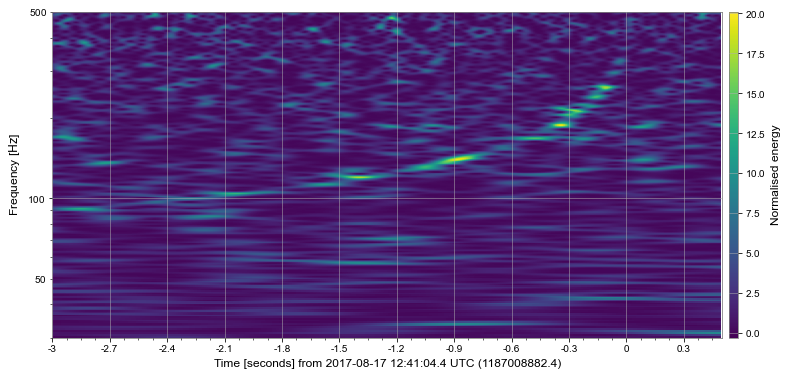

In [11]:
# We can also use the outseg option to zoom in around the merger:
#-- Use OUTSEG for small time range
hq2 = hdata.q_transform(frange=(30, 500), qrange=(80, 110), outseg=(gps-3,gps+0.5)) 
plot = hq2.plot()
ax = plot.gca()
ax.set_epoch(gps)
ax.set_yscale('log')
ax.colorbar(label="Normalised energy")

We can repeat the exercise using LIGO-Livingston data.

Fetched 1 URLs from www.gw-openscience.org for [1187008852 .. 1187008884))
Reading data... [Done]


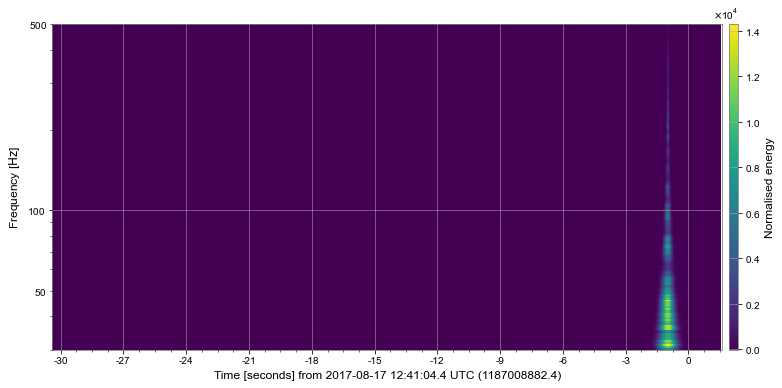

In [12]:
# download and filter the Livingston data:
ldata = TimeSeries.fetch_open_data('L1', *segment, verbose=True)

lq = ldata.q_transform(frange=(30, 500), qrange=(100, 110))
plot = lq.plot()
ax = plot.gca()
ax.set_epoch(gps)
ax.set_yscale('log')
ax.colorbar(label="Normalised energy")

we can see a large blob of energy that is 1000 times louder than what we see in the LIGO-Hanford data.

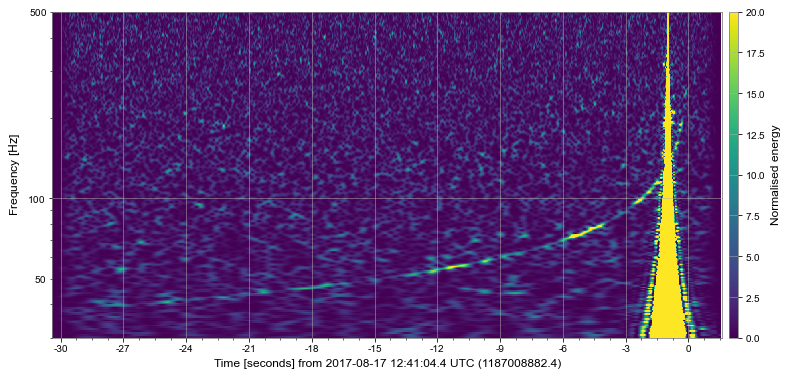

In [13]:
#an instrumental glitch almost exactly overlaps the BNS signal in LIGO-Livingston. 
#But, we can rescale things to see the astrophyscal signal better:

plot.colorbars[0].mappable.set_clim(0,20)
plot.refresh()
plot

Now we can see the BNS signal track all the way back to T=-28 seconds in LIGO-Livingston data!

However, there is still the large glitch that makes it difficult to see the signal near merger. This loud of a glitch is particularly troublesome for any analyses that want to use this data. In order to address these types of loud glitches, a technique called **gating** is commonly used.  
- We will use the `gwpy.TimeSeries.gate()` method to gate the data.  
- In order to apply a gate, the data is multiplied by a window function.  
- The gwpy method we are using uses an inverse Planck window, but other windows, such as a Turkey window, are also commonly used.
- After multiplying by the window, the data directly surrounding the glitch will be zeroed.
- The window function inlcudes a transition from 0 to 1 so that there are not any discontinuities introduced.
- An additional feature of `gwpy.TimeSeries.gate()` is that the times that are gated are identified automatically.
- This is done by finding data points with an absolute value above some threshold in the whitened data. The default threshold is 50.

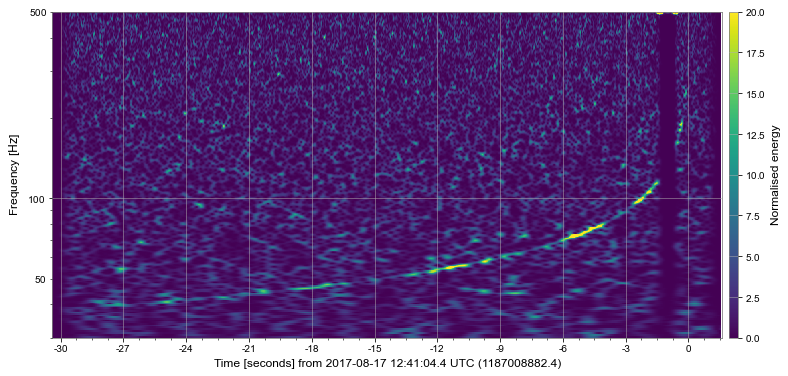

In [14]:
# apply gates to the Livingston data and remake the plot:

gated_ldata = ldata.gate(tzero=0.25, tpad=0.25)

gated_lq = gated_ldata.q_transform(frange=(30, 500), qrange=(100, 110))
plot = gated_lq.plot()
ax = plot.gca()
ax.set_epoch(gps)
ax.set_yscale('log')
ax.colorbar(label="Normalised energy")
plot.colorbars[0].mappable.set_clim(0,20)

some of our data is now missing. Hence gating can be a great way to deal with loud glitches, but only should be used sparingly.

# Q-scan challenge

- download the data for all detectors involved with the GW170814 detection. Which detectors registered this event?
- generate a Q-scan for the data in each detector. (Hint: try using a much smaller time range and Q-range than you did for GW170817)

## Question
- Download the data for the LIGO-Livingston detector (L1) around the GW170814 detection, and make a Q-scan of the data. The signal is visible for how about how much time?

In [16]:
%matplotlib inline
import gwpy
from gwosc.datasets import event_gps
from gwpy.timeseries import TimeSeries

Fetched 1 URLs from www.gw-openscience.org for [1186741349 .. 1186742373))
Reading data... [Done]


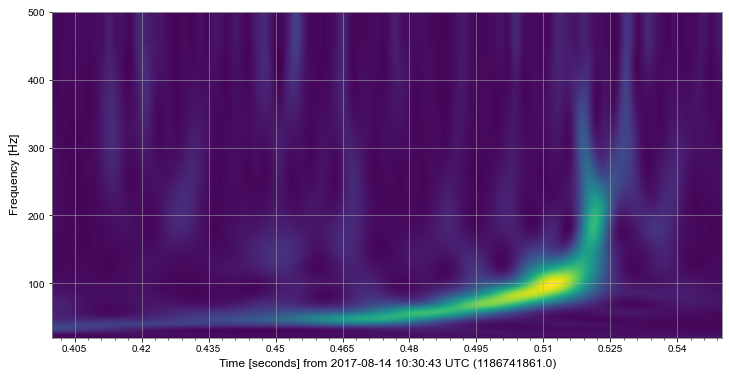

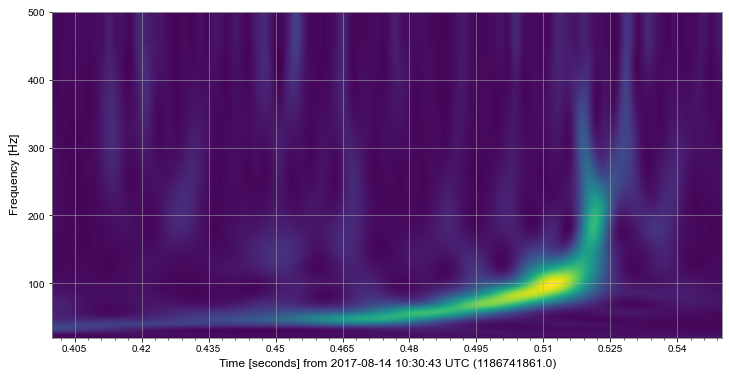

In [23]:
from gwosc.datasets import event_gps
from gwpy.timeseries import TimeSeries, TimeSeriesDict
gps = event_gps('GW170814')
data = TimeSeries.fetch_open_data('L1', int(gps)-512, int(gps)+512, cache=True, verbose=True)
QT = data.q_transform(frange=(20, 500), qrange=(4, 12), outseg=(gps-.1,gps+.05))
QT.plot()